In [124]:
import warnings; warnings.filterwarnings("ignore")
import numpy as np; import scipy as sp; import pandas as pd
import matplotlib.pyplot as plt
import mne; mne.utils.set_log_level('error')
from functools import reduce
from time import time; import os
from pickle import load
from ipywidgets import Dropdown, Checkbox, HBox, Layout

#### Define helper functions

In [125]:
def select_dataset(directory,ext_in,ext_out=None,show_all=False,single=False):
    files = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(directory)) for f in fn if os.path.isfile(os.path.join(dp, f)) and ext_in in f]
    done = [] if ext_out is None else [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(directory)) for f in fn if os.path.isfile(os.path.join(dp, f)) and ext_out in f]
    subjects = [f[len(directory):-len(ext_in)] for f in files if show_all or ext_out is None or (f[:-len(ext_in)]+ext_out not in done)]
    if single:
        widget = [Dropdown(options=subjects, description='Subject: ',disabled=False)]
    else:
        widget = [Checkbox(True, description=f[len(directory):-len(ext_in)], indent=False) for f in files if show_all or ext_out is None or (f[:-len(ext_in)]+ext_out not in done)]
    return HBox(widget,layout=Layout(width='100%',display='inline-flex',flex_flow='row wrap'))

def get_selection(hbox,fragments=False):
    if type(hbox)==HBox and len(hbox.children):
        if type(hbox.children[0])==Dropdown:
            return [hbox.children[0].value] if not fragments else [c for c in hbox.children[0].options if hbox.children[0].value in c]
        else:
            return [c.description for c in hbox.children if c.value]
    else:
        return None
def get_trial_pos_in_block(block_type,block_index,df):
    pos = np.zeros_like(df.BlockIndex)*0.
    mask = np.logical_and(df.BlockType==block_type,df.BlockIndex==block_index)
    pos[mask] = (np.arange(np.sum(mask))+1)/np.sum(mask)
    return pos
def get_masked(subject,funs=[lambda x: np.logical_and(x.StimulusType<200,x.FeedbackType=='negative'), lambda x: np.logical_and(x.StimulusType<200,x.FeedbackType=='positive')]):
    file = open(d+subject+ext,"rb")
    dct = load(file)
    df = pd.read_csv(d+subject+".csv")
    #df['BlockPosition']=np.sum([get_trial_pos_in_block(a,b,df) for a,b in zip(['visual/right','visual/right','visual/left','visual/left','auditive/right','auditive/right','auditive/left','auditive/left'],[1,2,1,2,1,2,1,2])],axis=0)
    ch = sorted(set(dct.keys()))
    fp = sorted(set([k[0] for k in [d for d in dct.values()][0].keys()]))
    fa = sorted(set([k[1] for k in [d for d in dct.values()][0].keys()]))
    dat = np.array([[[dct[c][(p,a)][0].T for p in fp] for a in fa] for c in ch]).T
    return [dat[fn(df),:,:,:,:] for fn in funs]
def plot_masked_tfr(T,m,ax,labels={},kwargs={}):
    ax.imshow(np.repeat(T,1,-1),origin='lower',cmap='Greys')
    sig_T = np.copy(T)
    sig_T[np.logical_not(m)]=np.nan
    im = ax.imshow(np.repeat(sig_T,1,-1),origin='lower',cmap='Spectral_r',**kwargs);
    if 'x' in labels.keys():
        xticks,xlabels = labels.get('x')
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels)
    if 'y' in labels.keys():
        yticks,ylabels = labels.get('y')
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)
    return im

#### Select dataset

In [126]:
locktype="stimulus"
d="G:/Julia/New_Datasets/RawData_new/"
ext="-bytrial.pac.json"
box=select_dataset(d,"."+locktype+ext);box

#### Get parameter ranges

In [137]:
subject=get_selection(box)[0]
file = open(d+subject+"."+locktype+ext,"rb")
dct = load(file)
ch = sorted(set(dct.keys()))
fp = sorted(set([k[0] for k in [d for d in dct.values()][0].keys()]))
fa = sorted(set([k[1] for k in [d for d in dct.values()][0].keys()]))

#### Filter data

In [140]:
funs = [
    lambda x: np.logical_and(x.BlockType=='train',x.FeedbackType=='positive'),
    lambda x: np.logical_and(x.BlockType=='train',x.FeedbackType=='negative')
]
data = [get_masked(subject+"."+locktype,funs) for subject in get_selection(box)]
mean_data = np.mean(np.vstack([list(z) for z in zip(*data)][1]),axis=0)-np.mean(np.vstack([list(z) for z in zip(*data)][0]),axis=0)

In [121]:
#[[d.shape for d in dat] for dat in data]

#### Run statistics

In [123]:
T,c,p,_ = mne.stats.permutation_cluster_test([np.vstack([list(z) for z in zip(*data)][0]),np.vstack([list(z) for z in zip(*data)][1])],connectivity=None)
sig_cls = [d for d,q in zip(c,p) if q<.05]
if len(sig_cls)<1:
    sig_cls = np.expand_dims(np.zeros_like(T)>0,axis=0)

#### PAC time series, T-values for correct vs incorrect responses

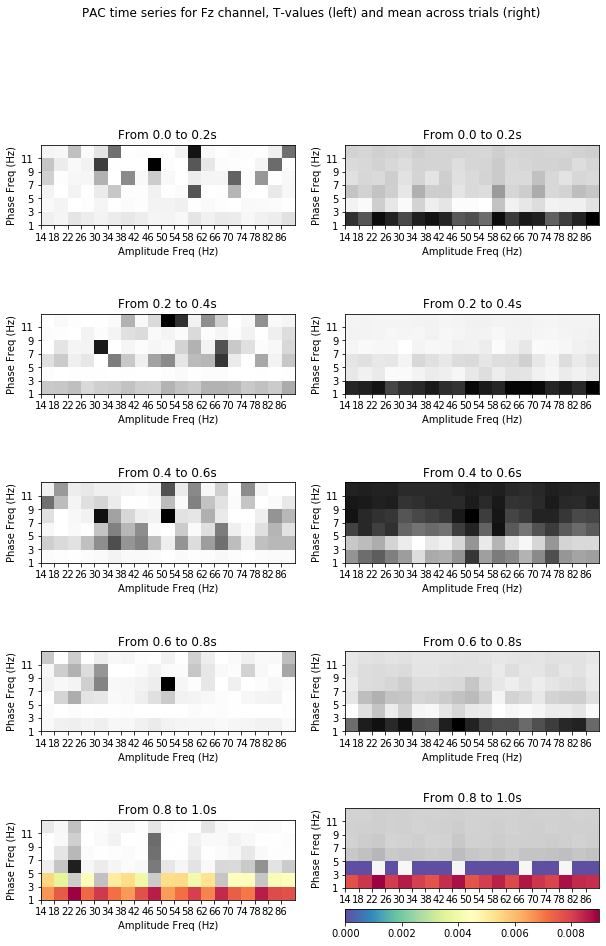

In [141]:
fig,axs = plt.subplots(5,2,figsize=(10,15))
#axs = [a for a in axs]
amin=np.min(T);amax=np.max(T)
bmax=np.max(mean_data);bmin=0#np.min(corr_data);
times = [[0.,.2],[.2,.4],[.4,.6],[.6,.8],[.8,1.]]
for i,ax in enumerate(axs):
    a,b = ax
    chidx = 0
    jm = plot_masked_tfr(T[i,:,:,chidx],np.any(sig_cls,axis=0)[i,:,:,chidx],a,labels={'x':(np.arange(len(fa))-.5,[f[0] for f in sorted(fa)]),'y':(np.arange(len(fp))-.5,[f[0] for f in sorted(fp)])},kwargs={'vmin':amin,'vmax':amax})
    a.set_ylabel("Phase Freq (Hz)")
    a.set_xlabel("Amplitude Freq (Hz)")
    a.set_title("From {} to {}s".format(*times[i]))
    im = plot_masked_tfr(mean_data[i,:,:,chidx],np.any(sig_cls,axis=0)[i,:,:,chidx],b,labels={'x':(np.arange(len(fa))-.5,[f[0] for f in sorted(fa)]),'y':(np.arange(len(fp))-.5,[f[0] for f in sorted(fp)])},kwargs={'vmin':bmin,'vmax':bmax})
    b.set_ylabel("Phase Freq (Hz)")
    b.set_xlabel("Amplitude Freq (Hz)")
    b.set_title("From {} to {}s".format(*times[i]))
fig.suptitle("PAC time series for Fz channel, T-values (left) and mean across trials (right)");
fig.colorbar(im,orientation='horizontal');

#### Snippets:

In [151]:
df = pd.read_csv(d+subject+".stimulus.csv")
df

,Unnamed: 0,LockType,LockSample,BlockType,BlockIndex,StimulusType,ResponseType,ResponseTimes,FeedbackType,TrialEvents
0,11,stimulus,134069,train,2,rtl/AB/incorrect,right/incorrect,1.216,negative,"OrderedDict([('Stim/5', 132489), ('Stim/10', 1..."
1,26,stimulus,137494,train,2,rtl/AB/correct,right/correct,1.436,positive,"OrderedDict([('Stim/5', 136205), ('Stim/10', 1..."
2,41,stimulus,141242,train,2,ltr/CD/incorrect,right/correct,1.401,positive,"OrderedDict([('Stim/5', 139749), ('Stim/10', 1..."
3,56,stimulus,145230,train,2,rtl/EF/correct,left/incorrect,1.310,negative,"OrderedDict([('Stim/5', 143550), ('Stim/10', 1..."
4,71,stimulus,148914,train,2,ltr/CD/correct,right/incorrect,1.275,negative,"OrderedDict([('Stim/5', 147397), ('Stim/10', 1..."
5,86,stimulus,152810,train,2,rtl/AB/correct,left/incorrect,1.873,negative,"OrderedDict([('Stim/5', 151072), ('Stim/10', 1..."
6,101,stimulus,156878,train,2,rtl/EF/correct,right/correct,1.414,positive,"OrderedDict([('Stim/5', 155565), ('Stim/10', 1..."
7,116,stimulus,160744,train,2,rtl/AB/correct,right/correct,1.068,positive,"OrderedDict([('Stim/5', 159183), ('Stim/10', 1..."
8,131,stimulus,164053,train,2,ltr/AB/correct,right/incorrect,1.583,negative,"OrderedDict([('Stim/5', 162634), ('Stim/10', 1..."
9,146,stimulus,167967,train,2,ltr/EF/incorrect,right/correct,2.037,positive,"OrderedDict([('Stim/5', 166488), ('Stim/10', 1..."


In [158]:
pac_values = dct['Fz'][((7,9),(22,26))][0]
pac_values

(360, 5)

In [159]:
amps_per_bin = dct['Fz'][((7,9),(22,26))][1]
amps_per_bin.shape

(360, 20, 5)